# ML Zoomcamp - Capstone Project

### Project Brief

You have been hired as a data scientist at Discount Motors, a used car dealership in the UK. The dealership is expanding and has hired a large number of junior salespeople. Although promising, these junior employees have difficulties pricing used cars that arrive at the dealership. Sales have declined 18% in recent months, and management would like your help designing a tool to assist these junior employees.

To start with, they would like you to work with the Toyota specialist to test your idea(s). They have collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the head of sales in a 10 minute presentation. The head of sales has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

### Importing and installing the necessary librarys

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import export_graphviz
import pydot
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn.preprocessing import scale
from sklearn.datasets import make_regression
from sklearn.preprocessing import scale 
from sklearn.linear_model import  RidgeCV, LassoCV
import xgboost as xgb
from IPython.display import Image
import matplotlib
import plotly.graph_objects as go
import bentoml

### Get the data

In [288]:
data = pd.read_csv(r'C:\Users\User\Desktop\Ml Zoomcamp\Capstone project/toyota.csv',sep=',')

### EDA

In [141]:
data .columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

In [142]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [143]:
data.count()

model           6738
year            6738
price           6738
transmission    6738
mileage         6738
fuelType        6738
tax             6738
mpg             6738
engineSize      6738
dtype: int64

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [145]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


In [146]:
data.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

#### Note 1

As we can see there's no any missing values and we assume that all columns will be useful to the analysis Later we'll check extreme values that could inhibit prediction power of the model we choose.


Price is the feature that we are predicting. Looking at price distribuition we can see that:

*  Most of the cars costs less than $20,000 but there is considerable number of cars above this price.

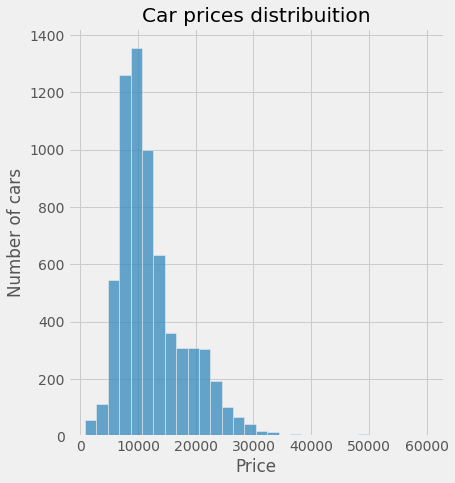

In [147]:
sns.histplot(data['price'], bins=30)
plt.xlabel('Price')
plt.ylabel('Number of cars')
plt.title('Car prices distribuition')
plt.style.use('ggplot')
plt.show()

In [148]:
def plot_numerical(feature):
    ax = sns.lmplot(x=feature, y='price', data=data)
    ax.set_xticklabels(rotation=85)
    plt.title('Price vs ' + feature, fontsize=18)
    plt.ylabel('Mean Price', fontsize=12)
    plt.xlabel( feature, fontsize=12)
    plt.figure(figsize=(15,8))
    plt.show()
    
def plot_categorical(feature, figsize=None):
    df = data.groupby([feature])['price'].describe()[['mean','count']]

    labels = df.index.values
    x = np.arange(len(labels))
    width = 0.9
    fig, ax1 = plt.subplots(figsize=(13, 5))

  
    rects2 = ax1.bar(x, df['count'], width/3, label='mean')
   
    ax1.set_ylabel('Number of cars', fontsize=12)
    ax1.set_title('Mean price and number of cars by ' + feature, fontsize=18)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=85)
    ax1.grid(False)
    ax1.legend()

 
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean Price', fontsize=12)
    ax2.set_xlabel(feature, fontsize=12)
    ax2.plot(x, df['mean'], color='green', linestyle='solid')
    ax2.grid(False)

   
    for i, rect in enumerate(rects2):
        height = int(round(rect.get_height()))
        ax1.annotate('{}'.format(int(df['count'].iloc[i])),
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', color='black')
    plt.show()

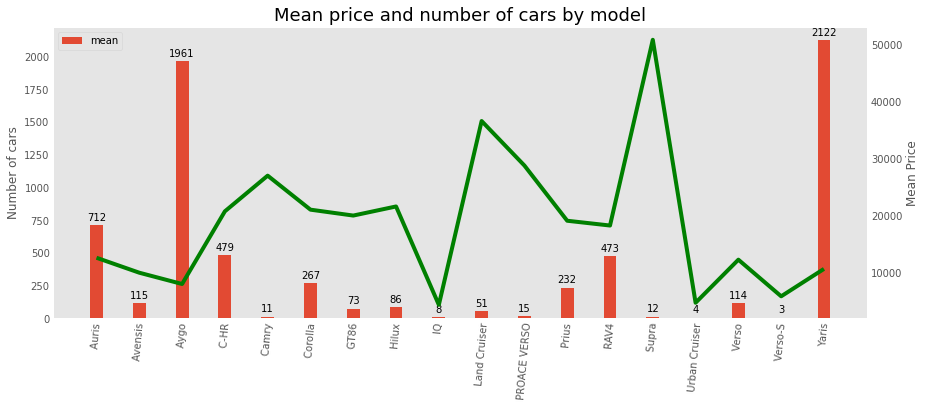

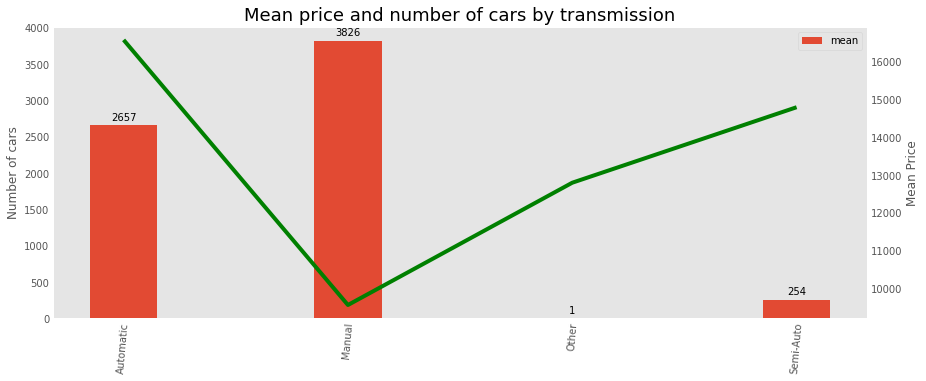

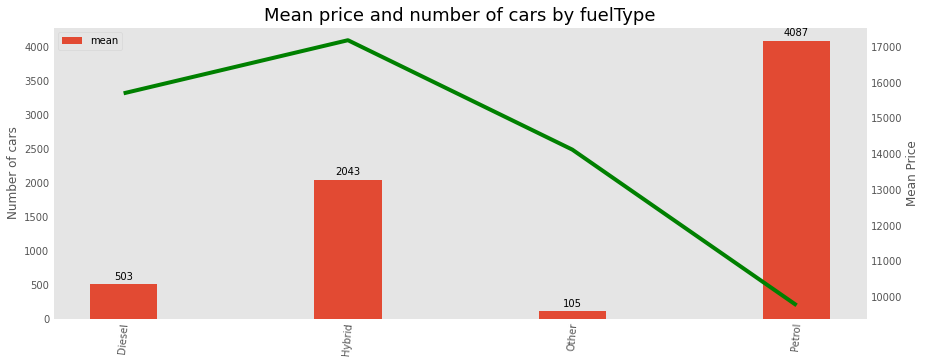

In [149]:
for feature in ['model', 'transmission', 'fuelType']:
    plot_categorical(feature)

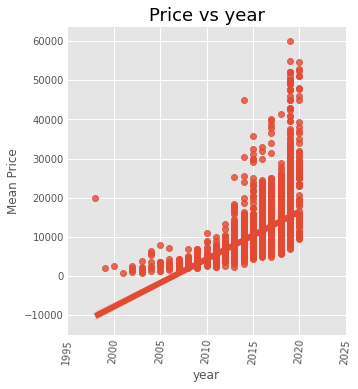

<Figure size 1080x576 with 0 Axes>

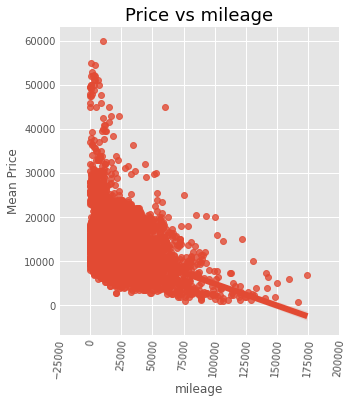

<Figure size 1080x576 with 0 Axes>

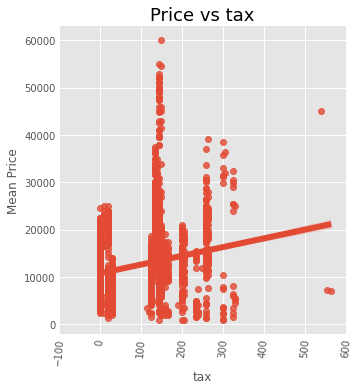

<Figure size 1080x576 with 0 Axes>

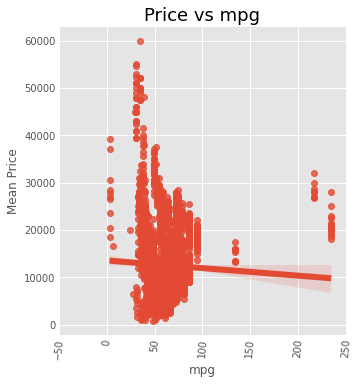

<Figure size 1080x576 with 0 Axes>

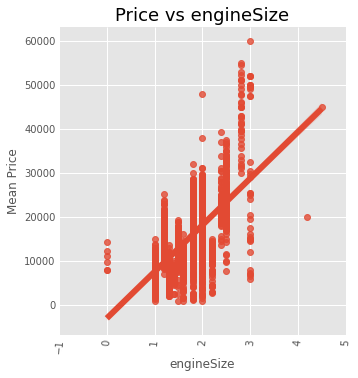

<Figure size 1080x576 with 0 Axes>

In [150]:
for feature in ['year', 'mileage', 'tax', 'mpg', 'engineSize']:
    plot_numerical(feature)

#### Note 2

* model - Supra models are the costliest ones while Aygo and Yaris are the most popular ones
* transmission - Manual has usually low cost
* fuelType - Petrol models are the cheapest ones
* year - new cars are sold at higher prices
* mileage - lower the mileage or car travelled, higher the price
* mpg - lower the mpg, higher the car price (usually heavy or luxury cars have lower mpg)
* engineSize - bigger the enginer, higher the price
* tax - generally higher the tax, higher the car price

In [214]:
categorical_features = ['model', 'transmission', 'fuelType']
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize','price']

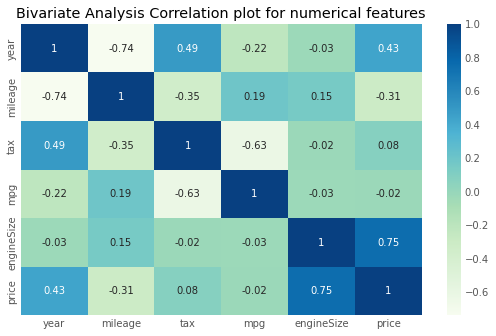

In [152]:
plt.figure(figsize=(8, 5))
sns.heatmap(round(data[numerical_features].corr(method='spearman'), 2), 
            annot=True, mask=None, cmap='GnBu')

plt.title('Bivariate Analysis Correlation plot for numerical features')
plt.show()

#### Note 3

Correlation between features: 

* year - mileage: High negative
* mpg - tax:  Negative, but not to high
* price - engine size: High Positive 

In [153]:
df = data.copy()
for i, feature in enumerate(categorical_features):
    le = LabelEncoder()

    
    le.fit(df[feature])
   
    
   
    df[feature] = le.transform(df[feature])


    columns = list(map(lambda x: feature+' '+str(x), list(le.classes_)))[1:]

In [154]:
# Calculating VIF
vif = pd.DataFrame()
vif["variables"] = [feature for feature in categorical_features+numerical_features if feature not in ['year','price']]
vif["VIF"] = [variance_inflation_factor(df[vif['variables']].values, i) for i in range(len(vif["variables"]))]
print(vif)

      variables        VIF
0         model   2.640893
1  transmission   2.903885
2      fuelType   6.306291
3       mileage   2.660140
4           tax   3.503499
5           mpg  10.542839
6    engineSize  12.809195


#### Note 4 
mpg and engineSize are high correlated each other. We maybe can use just one of them.

#### Looking at Outliers in numerical features.

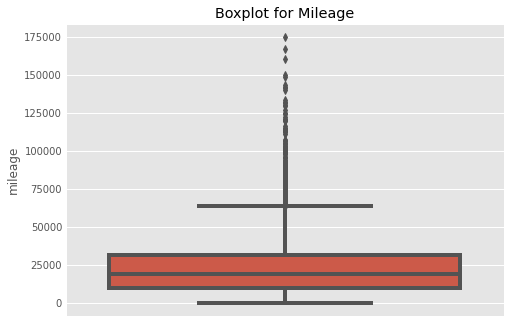

In [155]:
plt.figure(figsize=(7,5))
plt.title("Boxplot for Mileage")
bp = sns.boxplot(y='mileage',data=data)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
plt.show()

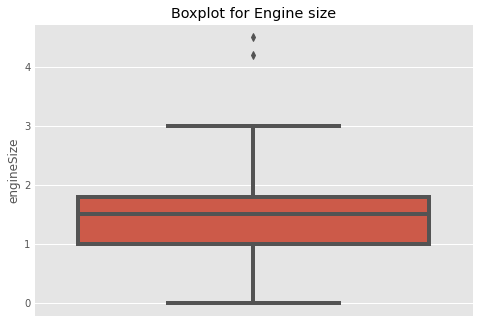

In [156]:
plt.figure(figsize=(7,5))
plt.title("Boxplot for Engine size")
plt.ylabel('Engine Size')
bp = sns.boxplot(y='engineSize',data=data)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
plt.show()

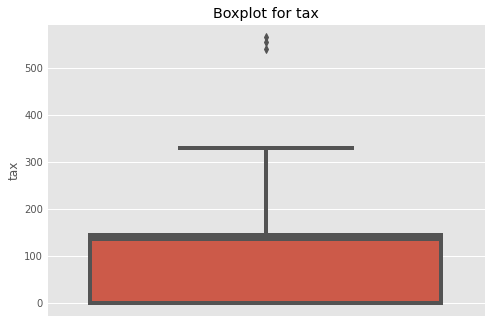

In [157]:
plt.figure(figsize=(7,5))
plt.title("Boxplot for tax")
plt.ylabel('tax')
bp = sns.boxplot(y='tax',data=data)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
plt.show()

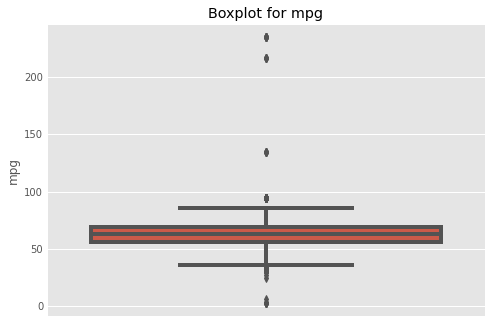

In [158]:
plt.figure(figsize=(7,5))
plt.title("Boxplot for mpg")
plt.ylabel('mpg')
bp = sns.boxplot(y='mpg',data=data)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
plt.show()

#### Percentage of outliers present in each variable

In [159]:
# Percentage of outliers present in each variable
outlier_percentage = {}
for feature in numerical_features:
    tempData = data.sort_values(by=feature)[feature]
    Q1, Q3 = tempData.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    Lower_range = Q1 - (1.5 * IQR)
    Upper_range = Q3 + (1.5 * IQR)
    outlier_percentage[feature] = round((((tempData<(Q1 - 1.5 * IQR)) | (tempData>(Q3 + 1.5 * IQR))).sum()/tempData.shape[0])*100,2)
outlier_percentage

{'year': 3.15,
 'mileage': 3.99,
 'tax': 0.04,
 'mpg': 3.09,
 'engineSize': 0.03,
 'price': 3.83}

#### Note 5 
Theres is not too much outliers in the hole dataset, but  the outliers in 'mpg' and 'mileage' can arise the model error.

#### Preparing the data

In [160]:
df = data.copy()

#### Label Encoding. 

In the dataset, there are 9 predictors. 3 of them are numerical variables while rest of them are categorical. In order to apply a machine learning models, we need numeric representation of the features. Therefore, all non-numeric features were transformed into numerical form.

In [161]:
le = LabelEncoder()

df[categorical_features] = df[categorical_features].apply(le.fit_transform)

#### Train the data.
In this process, 20% of the data was split for the test data and 80% was taken as train data.

In [162]:
y= df.price
X= df.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(5390, 8) (5390,)
(1348, 8) (1348,)


#### Scaling the data

The machine learning models will try to disregard coefficients of features that has low values without scale because their impact will be so small compared to the big value features.

Min-max scaler is appropriate for this the data that we want outliers to have reduced influence. 

In [163]:
sc = MinMaxScaler()   
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

In [164]:
X_train

array([[0.70588235, 0.68181818, 0.        , ..., 0.46017699, 0.16968131,
        0.48888889],
       [1.        , 0.95454545, 0.33333333, ..., 0.25663717, 0.19422911,
        0.33333333],
       [0.70588235, 0.81818182, 0.        , ..., 0.3539823 , 0.17527993,
        0.44444444],
       ...,
       [0.11764706, 0.81818182, 0.33333333, ..., 0.        , 0.28509905,
        0.22222222],
       [0.11764706, 0.95454545, 0.33333333, ..., 0.25663717, 0.23126615,
        0.22222222],
       [1.        , 0.77272727, 0.33333333, ..., 0.05309735, 0.2248062 ,
        0.28888889]])

#### Machine Learning Models

#### Random Forest

Random forest is a set of multiple decision trees. Deep decision trees may suffer from overfitting, but random forest prevents overfitting by creating trees on random subsets.

In [165]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [166]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 827.88
Mean Squared Error: 1644106.33
Root Mean Squared Error: 1282.23


 In general, the more trees give the better results.

In [167]:
regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [168]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 815.41
Mean Squared Error: 1528357.87
Root Mean Squared Error: 1236.27


Better as we expect

In [169]:
rf= regressor
features= df.drop('price', axis = 1)

feature_list = list(features.columns)

features = np.array(features)

#### Note 6
we see that there are seven leaf nodes. This tree uses only three variables: engine size,year and mpg. The leaf nodes do not have a question because these are where the final predictions are made. To classify a new point, simply move down the tree, using the features of the point to answer the questions until you arrive at a leaf node where the class is the prediction.

### Variable Importance

Variable Importance: In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importance of the variables.

In [170]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: engineSize           Importance: 0.57
Variable: year                 Importance: 0.27
Variable: mpg                  Importance: 0.05
Variable: mileage              Importance: 0.04
Variable: model                Importance: 0.03
Variable: transmission         Importance: 0.02
Variable: tax                  Importance: 0.02
Variable: fuelType             Importance: 0.0


The chart below is a bar plot of the feature importance to illustrate the disparities in the relative significance of the variables.Conventionally, reaching 90% of the cumulative importance is considered as a success.

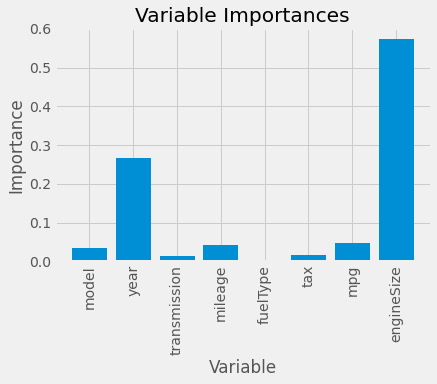

In [171]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

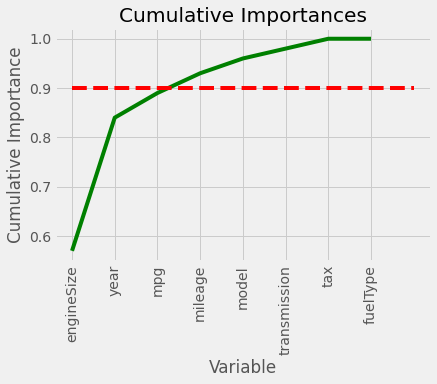

In [172]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 90% of importance retained
plt.hlines(y = 0.90, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance');
plt.title('Cumulative Importances');

In [173]:
# Find number of features for cumulative importance of 90%

# Add 1 because Python is zero-indexed
print('Number of features for 90% importance:', np.where(cumulative_importances > 0.90)[0][0] + 1)

Number of features for 90% importance: 4


In [174]:
# New random forest with only the most important variables
rf_most_important = RandomForestRegressor(n_estimators=200, random_state=0)

In [175]:
# Extract the most important features
features= df.drop('price', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)


important_indices = [feature_list.index('engineSize'), feature_list.index('year'), 
                     feature_list.index('mpg'), feature_list.index('mileage')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]

In [176]:
# Train the random forest
rf_most_important.fit(train_important, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

In [177]:
predictions = rf_most_important.predict(test_important)

In [178]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2))

Mean Absolute Error: 905.0
Mean Squared Error: 2005438.74
Root Mean Squared Error: 1416.14


####  Model with only important features: 
The features are: engineSize,year and mpg.  The ultimate purpose of the modelling is to get a smaller number of features that can give us a strong prediction. At this point, the model was run with only three important features. The new RMSE is 1416.14. This score is slightly worse than the full model. Therefore, it can not be considered as an improvement in both prediction power and computational cost.

#### Linear Regression

In [179]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mse(y_test, y_pred_lr))
rr = Ridge()
rr.fit(X_train, y_train)
y_pred_rr = rr.predict(X_test)
rmse_rr = np.sqrt(mse(y_test, y_pred_rr))
print('-------------Linear Regression-------------')
print("RMSE = {:.2f}".format((rmse_lr)))
accuracy = lr.score(X_test,y_test)
print('Accuracy = ', accuracy*100,'%')
print('-------------Ridge Regression--------------')
print("RMSE = {:.2f}".format((rmse_rr)))

-------------Linear Regression-------------
RMSE = 3025.93
Accuracy =  78.48443243477622 %
-------------Ridge Regression--------------
RMSE = 3029.96


In [180]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print(regressor.intercept_)#For retrieving the slope:
print(regressor.coef_)

-17465.06656189772
[ -2003.14190023  18372.72631841   -864.66799561 -13967.69224761
   -235.46208783  -1258.75770867   2454.29053317  52116.75488201]


In [181]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
model,-2003.141900
year,18372.726318
transmission,-864.667996
mileage,-13967.692248
fuelType,-235.462088
tax,-1258.757709
mpg,2454.290533
engineSize,52116.754882


In [182]:
OLS_pred= regressor.predict(X_train)

In [183]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_train, OLS_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_train, OLS_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, OLS_pred)),2))

Mean Absolute Error: 2044.81
Mean Squared Error: 8733442.07
Root Mean Squared Error: 2955.24


In [184]:
y_pred = regressor.predict(X_test)

In [185]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
round(df1,2)

,Actual,Predicted
381,37440,27522.38
2476,4159,749.02
2855,10600,11900.98
2018,8995,10010.38
2185,11000,11699.33
1894,11215,10389.88
2641,11295,13366.56
503,11995,16619.23
6091,19998,18041.80
2644,11295,13507.45


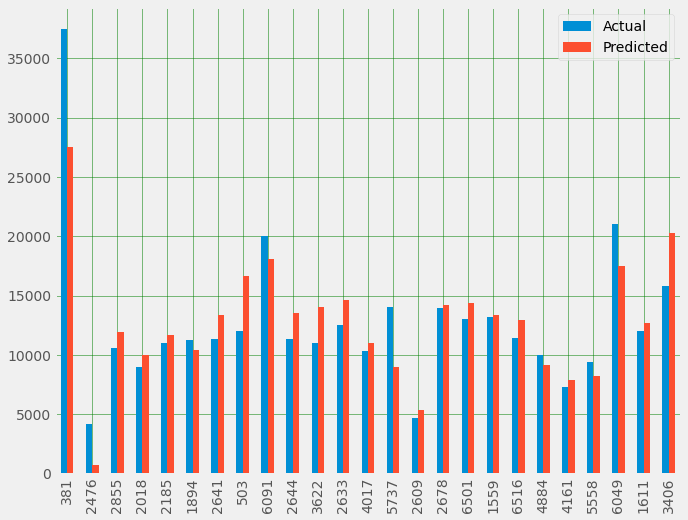

In [186]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [187]:
y_pred = regressor.predict(X_test)

In [188]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 2138.59
Mean Squared Error: 9156222.56
Root Mean Squared Error: 3025.93


#### Note 8

The performance of the linear regression is not much good compared to random forest

#### Ridge Regression

Ordinary least square (OLS) gives unbiased regression coefficients. Ridge regression and lasso allow to regularize (“shrink”) coefficients. In the chart below, it can be seen how coefficients are shringking with increasing value of alpha.

In order to find best alpha value in ridge regression, cross validation was applied

In [189]:
alphas = 10**np.linspace(10,-2,100)*0.5
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





0.005

In [190]:
# Fit a ridge regression on the training data
pred2 = ridgecv.predict(X_test)
# Use this model to predict the test data
print(pd.Series(ridgecv.coef_, index = X.columns))

model           -1962.470350
year            18315.555495
transmission     -909.752087
mileage        -13898.904025
fuelType         -381.494439
tax             -1145.519589
mpg              2178.405790
engineSize      51331.806100
dtype: float64


In [191]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, pred2),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, pred2),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, pred2)),2))

Mean Absolute Error: 2137.33
Mean Squared Error: 9158820.48
Root Mean Squared Error: 3026.35


Text(0.5, 1.0, 'Feature importance using Ridge Model')

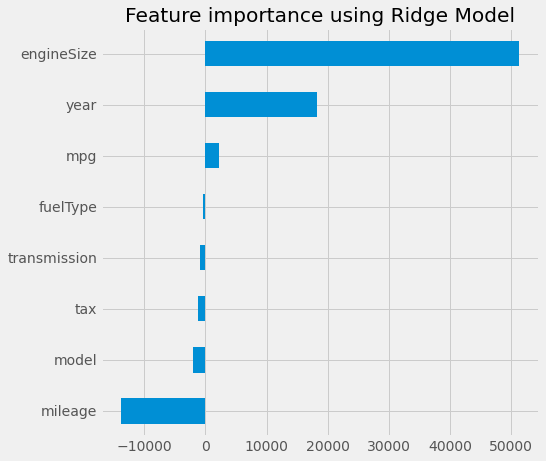

In [192]:
coef_ridge= pd.Series(ridgecv.coef_, index = X.columns)
imp_coef = coef_ridge.sort_values()
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")

Compared to OLS, the performance of ridge is almost same. Considering figure above, ridge regression suggest that three variables are the most important ones: engine size, year and mileage.

#### LASSO

In [193]:
reg = LassoCV( alphas = None, cv = 10, max_iter = 100000, normalize = True)
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X.columns)
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test))),2))

Best alpha using built-in LassoCV: 0.062289
Best score using built-in LassoCV: 0.779802
Root Mean Squared Error: 3025.57


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 



In [194]:
y_pred = reg.predict(X_test)

In [195]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 2138.28
Mean Squared Error: 9154066.6
Root Mean Squared Error: 3025.57


Text(0.5, 1.0, 'Feature importance using Lasso Model')

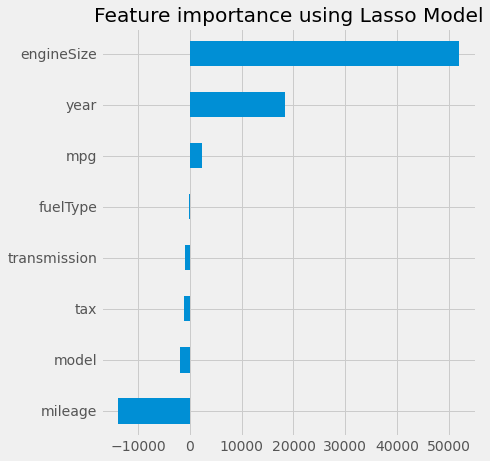

In [196]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 7.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [197]:
lasso001 = Lasso(alpha=100, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha=100:", train_score001)
print ("test score for alpha =100: ", test_score001)
print ("number of features used: for alpha =100: ", coeff_used001)

training score for alpha=100: 0.6998453751009572
test score for alpha =100:  0.7023300930943949
number of features used: for alpha =100:  5


Similar to the ridge results, lasso also gave that three variables are the most important ones: engine size, year and mileage. The performance was nearly the same

#### Xgboost

XGBoost is a specific implementation of the Gradient Boosting method which uses more accurate approximations to find the best tree model. 
As a first step, the objective parameter is set to be linear.

In [198]:
X_train

array([[0.70588235, 0.68181818, 0.        , ..., 0.46017699, 0.16968131,
        0.48888889],
       [1.        , 0.95454545, 0.33333333, ..., 0.25663717, 0.19422911,
        0.33333333],
       [0.70588235, 0.81818182, 0.        , ..., 0.3539823 , 0.17527993,
        0.44444444],
       ...,
       [0.11764706, 0.81818182, 0.33333333, ..., 0.        , 0.28509905,
        0.22222222],
       [0.11764706, 0.95454545, 0.33333333, ..., 0.25663717, 0.23126615,
        0.22222222],
       [1.        , 0.77272727, 0.33333333, ..., 0.05309735, 0.2248062 ,
        0.28888889]])

In [199]:
xg_reg = xgb.XGBRegressor( n_estimators = 1000,
    learning_rate=0.09, 
    min_child_weight=5,
    max_depth = 3,
    subsample = 0.75,
    seed=7)
xg_reg.fit(X_train,y_train)

predictions = xg_reg.predict(X_test)
rmse = np.sqrt(mse(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 1162.042190


In [200]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions),2))
print('Mean Squared Error:', round(mse(y_test, predictions),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2))

Mean Absolute Error: 755.04
Mean Squared Error: 1350342.05
Root Mean Squared Error: 1162.04


#### Diference between predictions and true values

In [201]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(y_pred))), y=y_pred,
                         mode='lines',
                         name='Prediction'))
fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_test,
                         mode='lines',
                         name='True value'))
fig.update_layout(title='Difference between predictions and true values ',
                   xaxis_title='Car',
                   yaxis_title='Mean Price in $',
                   width=700,
                   height=500,
                 )


fig.show()

#### Conclusion 	

it can be concluded that xgboost is the best model for the prediction for used car prices, because it gave the best MAE, MSE and RMSE values

#### Saving model to bentoml

In [202]:
bento_model = bentoml.xgboost.save_model("xgboost_regressor", xg_reg)

In [203]:
model_loaded = bentoml.xgboost.load_model("xgboost_regressor:latest")

In [319]:
def encoder():
    
    models = ['Auris', 'Avensis', 'Aygo', 'C-HR', 'Camry', 'Corolla',
           'GT86', 'Hilux', 'IQ', 'Land Cruiser', 'PROACE VERSO',
           'Prius', 'RAV4', 'Supra', 'Urban Cruiser', 'Verso',
           'Verso-S', 'Yaris']
    
    models_labels = np.arange(0,18,1)
    dict_models = dict(map(lambda i,j : (i,j) , models ,models_labels))

    transmission = ['Automatic', 'Manual', 'Other', 'Semi-Auto']
    transmission_labels = np.arange(0,5,1)
    dict_transmission = dict(map(lambda i,j : (i,j) , transmission ,transmission_labels))

    fuel_type = ['Diesel', 'Hybrid', 'Other', 'Petrol']
    fuel_type_labels =np.arange(0,5,1)
    dict_fuel_type= dict(map(lambda i,j : (i,j) , fuel_type ,fuel_type_labels))
    
    sample_dict['model'] = dict_models[sample_dict['model']]
    sample_dict['fuelType'] = dict_fuel_type[sample_dict['fuelType']]
    sample_dict['transmission'] = dict_transmission[sample_dict['transmission']]
    
    return sample_dict



In [363]:
categorical_features = ['model', 'transmission', 'fuelType']
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize','price']

le = LabelEncoder()
sc = MinMaxScaler()   

df[categorical_features] = df[categorical_features].apply(le.fit_transform)

y= np.array(df.price)
X= np.array(df.drop('price',axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train= sc.fit_transform(X_train)

In [384]:
sample_dict = {'model':'GT86','year':2016,'transmission':'Manual','mileage':24089,\
               'fuelType':'Petrol','tax':265,'mpg':36.2,'engineSize':2.0}

sample_dict['model'] = dict_models[sample_dict['model']]
sample_dict['fuelType'] = dict_fuel_type[sample_dict['fuelType']]
sample_dict['transmission'] = dict_transmission[sample_dict['transmission']]

values = sc.transform(np.array([list(sample_dict.values())]))
values

array([[0.35294118, 0.81818182, 0.33333333, 0.13810007, 1.        ,
        0.46902655, 0.14384152, 0.44444444]])

In [387]:
model_loaded.predict(values)[0]

15696.765

In [259]:
data[0:1]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0


In [356]:
df[categorical_features] = df[categorical_features].apply(le.fit_transform)
sample = df[0:1].drop('price',axis=1)
label=df[0:1].price
sample = sc.transform(sample)
sample


array([[0.35294118, 0.81818182, 0.33333333, 0.13810007, 1.        ,
        0.46902655, 0.14384152, 0.44444444]])

In [403]:
prediction = model_loaded.predict(sample)
print(f'Predicion:{prediction[0]}')
print(f'Price:{label}')
      

Predicion:15696.7646484375
Price:0    16000
Name: price, dtype: int64


In [406]:
round(prediction[0],2)

15696.76

In [345]:
sample

array([[0.35294118, 0.81818182, 0.33333333, 0.13810007, 1.        ,
        0.46902655, 0.14384152, 0.44444444]])

In [ ]:
{"model":"GT86","year":2016,"transmission":"Manual","mileage":24089,"fuelType":"Petrol","tax":265,"mpg":36.2,"engineSize":2.0}a